#### RQ3: With what accuracy we can infer high level concepts from visual feature?
- Using single/multiple/all visual features
- What feature are most useful for which high level concept?
- Which high level feature can or cannot be accurately inferred?
- What does this mean for our overall goal of predicting by standards? (As we know which of them is important)


In [2]:
# generic imports
import sys
import os
sys.path.append('../')
import helper
from definitions import *

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

# data structure
import itertools
from collections import Counter,defaultdict

import seaborn as sns

#stats amd ml
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm #https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.LogitResults.html
from scipy import stats
from sklearn import feature_selection
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import roc_curve


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
survey_path+'features-df.pkl'

'/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/features-df.pkl'

In [6]:

human_parts,object_classes =pickle.load(open(survey_path+'human-object-classes.pkl','rb'))
survey_photo_annotations =pickle.load(open(survey_path+'survey_photo_annotations.pkl','rb'))

#annotated body parts 
labeled_body_features = ['_'.join(human_parts[body_part].split()) 
                         for body_part in human_parts.keys()]


photo_df = pickle.load(open(os.path.join(survey_path, 'photo_df.pkl'), 'rb'))
mapping = pickle.load(open(survey_path +'mappings_pilot2','rb'))
feature_df = pickle.load(open(survey_path+'high-feature-df.pkl', 'rb'))
feature_df.shape, len(set(photo_df.index.values))

((4080, 13), 4080)

In [4]:
'''
Correlation between pairs of visual features
'''
for i in range(len(body_joint_prob_features)):
    for j in range(i+1, len(body_joint_prob_features)):
        c = stats.pearsonr(feature_df[body_joint_prob_features[i]], feature_df[body_joint_prob_features[j]])
        if  c[0]>=.3 and c[1]<.05:
            print('Cor({},{}) = {:.2f}'.format(body_joint_prob_features[i], body_joint_prob_features[j], c[0]))

Cor(nose_prob,neck_prob) = 0.68
Cor(nose_prob,Rsho_prob) = 0.64
Cor(nose_prob,Relb_prob) = 0.53
Cor(nose_prob,Rwri_prob) = 0.55
Cor(nose_prob,Lsho_prob) = 0.58
Cor(nose_prob,Lelb_prob) = 0.48
Cor(nose_prob,Lwri_prob) = 0.45
Cor(nose_prob,Rhip_prob) = 0.35
Cor(nose_prob,Lhip_prob) = 0.36
Cor(nose_prob,Lkne_prob) = 0.35
Cor(nose_prob,Lank_prob) = 0.47
Cor(nose_prob,Leye_prob) = 0.82
Cor(nose_prob,Reye_prob) = 0.71
Cor(nose_prob,Lear_prob) = 0.49
Cor(nose_prob,Rear_prob) = 0.46
Cor(neck_prob,Rsho_prob) = 0.90
Cor(neck_prob,Relb_prob) = 0.72
Cor(neck_prob,Rwri_prob) = 0.65
Cor(neck_prob,Lsho_prob) = 0.83
Cor(neck_prob,Lelb_prob) = 0.66
Cor(neck_prob,Lwri_prob) = 0.58
Cor(neck_prob,Rhip_prob) = 0.62
Cor(neck_prob,Rkne_prob) = 0.51
Cor(neck_prob,Rank_prob) = 0.49
Cor(neck_prob,Lhip_prob) = 0.57
Cor(neck_prob,Lkne_prob) = 0.48
Cor(neck_prob,Lank_prob) = 0.47
Cor(neck_prob,Leye_prob) = 0.59
Cor(neck_prob,Reye_prob) = 0.53
Cor(neck_prob,Lear_prob) = 0.50
Cor(neck_prob,Rear_prob) = 0.46
Cor(Rsho

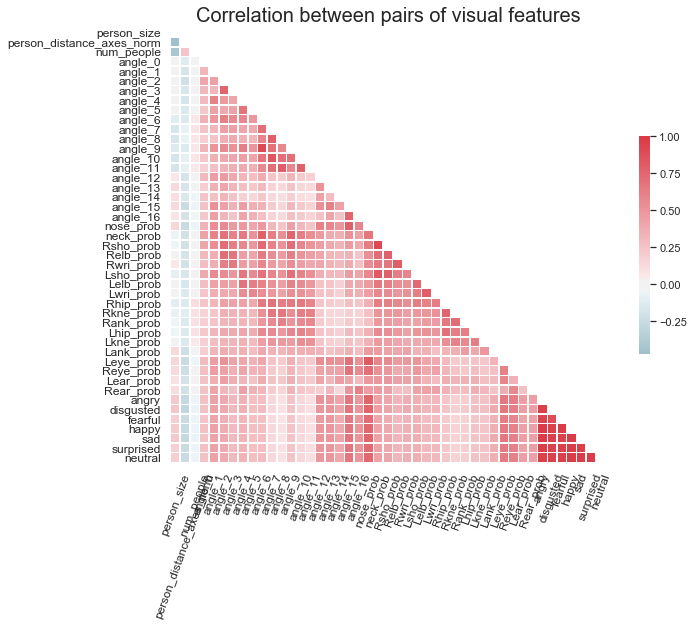

In [5]:
helper.plot_corr_matrix(mat=feature_df[visual_features].corr(),
                title='Correlation between pairs of visual features', ticks_fontsize=12)

In [6]:
subjects = feature_df[feature_df.label==1]
bystanders = feature_df[feature_df.label==0]

helper.data_stat(feature_df)
len(subjects),len(subjects[subjects.Human_eye>=1])
#subjects[subjects.Human_eye>=1][['Human_eye']].sum()

Total: 4080
Subject:1065, bystander:763, neither:278
Definitely subject:1222, Definitely bystander:752

Subject: 2287 (56.05%), Bystander: 1515 (37.13%), Neither:278(6.81%)


(2287, 34)

In [9]:
#feature_df[feature_df.Human_head>=1]
feature_df.groupby('label').mean()[labeled_body_features]

,Human_eye,Human_beard,Human_mouth,Human_body,Human_foot,Human_leg,Human_ear,Human_hair,Human_head,Human_arm,Human_nose,Human_hand
label,,,,,,,,,,,,
-1,0.006601,0.000660,0.003960,0.021122,0.003960,0.021122,0.006601,0.038284,0.038944,0.031023,0.003300,0.006601
0,0.010791,0.000000,0.000000,0.021583,0.000000,0.007194,0.000000,0.061151,0.035971,0.025180,0.000000,0.025180
1,0.031045,0.000875,0.019676,0.022737,0.004373,0.018365,0.007433,0.043725,0.038916,0.047223,0.022737,0.040665


In [10]:
feature_df.groupby('label').mean()[link_angle_features]

,angle_0,angle_1,angle_2,angle_3,angle_4,angle_5,angle_6,angle_7,angle_8,angle_9,angle_10,angle_11,angle_12,angle_13,angle_14,angle_15,angle_16
label,,,,,,,,,,,,,,,,,
-1,76.389820,82.249688,87.220278,53.255183,82.679613,53.666090,94.901481,67.187658,54.455409,94.782311,68.579633,51.834932,32.387406,15.628140,52.378623,38.310209,40.773410
0,93.641728,113.134315,119.760620,78.628111,109.482511,72.346379,122.567355,83.274463,52.287984,118.948654,88.189232,59.034736,52.425101,28.137935,81.413543,67.826598,66.011992
1,126.003965,132.297478,163.249925,103.002788,137.713523,95.366544,142.499135,85.140101,63.147491,131.463427,84.029240,61.505281,66.417761,35.367519,125.551054,85.253778,93.531547


In [11]:
feature_df.groupby('label').mean()[face_exp_feaures]

,angry,disgusted,fearful,happy,sad,surprised,neutral
label,,,,,,,
-1,0.064103,0.081974,0.039780,0.049968,0.055500,0.050408,0.052326
0,0.100338,0.131504,0.060792,0.077515,0.086837,0.077408,0.080714
1,0.127222,0.171270,0.075294,0.097309,0.111215,0.096674,0.101078


### Predict high-level-concenpts using visual features

In [8]:
def do_regression(data, predictors, response, normalize=True):
    X = data[predictors]
    if normalize:
        X = X.apply(stats.zscore)
    X = sm.add_constant(X)
    y = data[response]
    return sm.OLS(endog=y, exog=X).fit(disp = False)

#### Predict 'Posing'

In [9]:
'''One visual feature at a time'''
for vf in visual_features:
    print(do_regression(feature_df, [vf], 'posing_num').summary())

                            OLS Regression Results                            
Dep. Variable:             posing_num   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     806.7
Date:                Thu, 24 Oct 2019   Prob (F-statistic):          4.43e-162
Time:                        00:14:40   Log-Likelihood:                -7380.0
No. Observations:                4080   AIC:                         1.476e+04
Df Residuals:                    4078   BIC:                         1.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.7395      0.023    -31.975      

KeyError: "['angle_0'] not in index"

In [14]:
'''Use all labeled body features'''
print(do_regression(feature_df, labeled_body_features, 'posing_num').summary())

                            OLS Regression Results                            
Dep. Variable:             posing_num   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.268
Date:                Wed, 10 Apr 2019   Prob (F-statistic):           0.000102
Time:                        15:21:05   Log-Likelihood:                -7728.6
No. Observations:                4080   AIC:                         1.548e+04
Df Residuals:                    4067   BIC:                         1.557e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7395      0.025    -29.317      

In [15]:
'''Use all body-joint probabilities'''
print(do_regression(feature_df, body_joint_prob_features, 'posing_num').summary())

                            OLS Regression Results                            
Dep. Variable:             posing_num   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     44.69
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.77e-144
Time:                        15:21:06   Log-Likelihood:                -7379.5
No. Observations:                4080   AIC:                         1.480e+04
Df Residuals:                    4061   BIC:                         1.492e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7395      0.023    -31.912      0.0

In [16]:
'''Use all body-link angles'''
print(do_regression(feature_df, link_angle_features, 'posing_num').summary())

                            OLS Regression Results                            
Dep. Variable:             posing_num   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     46.29
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          3.57e-142
Time:                        15:21:06   Log-Likelihood:                -7386.9
No. Observations:                4080   AIC:                         1.481e+04
Df Residuals:                    4062   BIC:                         1.492e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7395      0.023    -31.858      0.0

In [17]:
'''Use all body-joint-probs and body-link angles'''
print(do_regression(feature_df, body_joint_prob_features+link_angle_features, 'posing_num').summary())

                            OLS Regression Results                            
Dep. Variable:             posing_num   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     28.71
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.69e-166
Time:                        15:21:06   Log-Likelihood:                -7295.5
No. Observations:                4080   AIC:                         1.466e+04
Df Residuals:                    4044   BIC:                         1.489e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7395      0.023    -32.508      0.0

In [19]:
'''Use other visual features'''
print(do_regression(feature_df, ['person_size','person_distance','num_people'], 'posing_num').summary())

                            OLS Regression Results                            
Dep. Variable:             posing_num   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     345.0
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.15e-199
Time:                        15:21:06   Log-Likelihood:                -7286.5
No. Observations:                4080   AIC:                         1.458e+04
Df Residuals:                    4076   BIC:                         1.461e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.7395      0.023    -

In [34]:
'''Use all features'''
print(do_regression(feature_df,  link_angle_features+body_joint_prob_features+face_exp_feaures+
                    ['person_size','person_distance','num_people'], 'posing_num').summary())

                            OLS Regression Results                            
Dep. Variable:             posing_num   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     44.05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.73e-310
Time:                        15:24:44   Log-Likelihood:                -6932.8
No. Observations:                4080   AIC:                         1.396e+04
Df Residuals:                    4034   BIC:                         1.425e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.7395      0.021    -

#### Predict 'replacable'

In [21]:
'''One visual feature at a time'''
for vf in visual_features:
    print(do_regression(feature_df, [vf], 'replacable_num').summary())

                            OLS Regression Results                            
Dep. Variable:         replacable_num   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     911.3
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          7.22e-181
Time:                        15:21:06   Log-Likelihood:                -7010.5
No. Observations:                4080   AIC:                         1.402e+04
Df Residuals:                    4078   BIC:                         1.404e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4528      0.021     21.434      

In [22]:
'''Use all body-joint-probs'''
print(do_regression(feature_df, body_joint_prob_features, 'replacable_num').summary())

                            OLS Regression Results                            
Dep. Variable:         replacable_num   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     63.49
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          8.47e-203
Time:                        15:21:07   Log-Likelihood:                -6916.1
No. Observations:                4080   AIC:                         1.387e+04
Df Residuals:                    4061   BIC:                         1.399e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4528      0.021     21.890      0.0

In [23]:
'''Use body-link angles'''
print(do_regression(feature_df, link_angle_features, 'replacable_num').summary())

                            OLS Regression Results                            
Dep. Variable:         replacable_num   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     49.75
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.35e-152
Time:                        15:21:07   Log-Likelihood:                -7036.1
No. Observations:                4080   AIC:                         1.411e+04
Df Residuals:                    4062   BIC:                         1.422e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4528      0.021     21.258      0.0

In [24]:
'''Use all body-joint-probs and body-link angles'''
print(do_regression(feature_df, body_joint_prob_features+link_angle_features, 'replacable_num').summary())

                            OLS Regression Results                            
Dep. Variable:         replacable_num   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     34.68
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          4.28e-201
Time:                        15:21:07   Log-Likelihood:                -6886.4
No. Observations:                4080   AIC:                         1.384e+04
Df Residuals:                    4044   BIC:                         1.407e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4528      0.021     22.004      0.0

In [25]:
print(do_regression(feature_df, ['person_size','person_distance','num_people'], 'replacable_num').summary())

                            OLS Regression Results                            
Dep. Variable:         replacable_num   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     447.6
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          2.38e-251
Time:                        15:21:07   Log-Likelihood:                -6841.0
No. Observations:                4080   AIC:                         1.369e+04
Df Residuals:                    4076   BIC:                         1.372e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4528      0.020     

In [36]:
'''Use all link-angle + body-joint-probs + other'''
print(do_regression(feature_df, body_joint_prob_features+link_angle_features +
    ['person_size','person_distance','num_people'], 'replacable_num').summary())

                            OLS Regression Results                            
Dep. Variable:         replacable_num   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     34.68
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          4.28e-201
Time:                        15:26:12   Log-Likelihood:                -6886.4
No. Observations:                4080   AIC:                         1.384e+04
Df Residuals:                    4044   BIC:                         1.407e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4528      0.021     22.004      0.0

### Predict 'comfort'

In [27]:
'''Use facial expressions'''
print(do_regression(feature_df, face_exp_feaures,'comfort_num').summary())

                            OLS Regression Results                            
Dep. Variable:            comfort_num   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     110.4
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.38e-148
Time:                        15:21:07   Log-Likelihood:                -5317.3
No. Observations:                4080   AIC:                         1.065e+04
Df Residuals:                    4072   BIC:                         1.070e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8210      0.014     58.813      0.0

In [28]:
'''Use other features'''
print(do_regression(feature_df, body_joint_prob_features,'comfort_num').summary())

                            OLS Regression Results                            
Dep. Variable:            comfort_num   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     52.44
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          5.97e-169
Time:                        15:21:07   Log-Likelihood:                -5245.4
No. Observations:                4080   AIC:                         1.053e+04
Df Residuals:                    4061   BIC:                         1.065e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8210      0.014     59.778      0.0

In [29]:
'''Use other features'''
print(do_regression(feature_df, ['person_size','num_people','person_distance'],'comfort_num').summary())

                            OLS Regression Results                            
Dep. Variable:            comfort_num   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     259.0
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          7.77e-154
Time:                        15:21:07   Log-Likelihood:                -5315.8
No. Observations:                4080   AIC:                         1.064e+04
Df Residuals:                    4076   BIC:                         1.066e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8210      0.014     

In [30]:
'''Use all features'''
print(do_regression(feature_df,  link_angle_features+body_joint_prob_features+face_exp_feaures+
                    ['person_size','person_distance','num_people'], 'replacable_num').summary())

                            OLS Regression Results                            
Dep. Variable:         replacable_num   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     53.24
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:21:07   Log-Likelihood:                -6470.9
No. Observations:                4080   AIC:                         1.303e+04
Df Residuals:                    4034   BIC:                         1.332e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4528      0.019     

### Predict 'awareness'

In [31]:
'''Use facial expressions'''
print(do_regression(feature_df, face_exp_feaures,'was_aware_num').summary())

                            OLS Regression Results                            
Dep. Variable:          was_aware_num   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     132.7
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          1.96e-176
Time:                        15:21:07   Log-Likelihood:                -7400.8
No. Observations:                4080   AIC:                         1.482e+04
Df Residuals:                    4072   BIC:                         1.487e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1237      0.023     -5.319      0.0

In [32]:
'''Use link-angle + facial expressions'''
print(do_regression(feature_df, face_exp_feaures + link_angle_features,'was_aware_num').summary())

                            OLS Regression Results                            
Dep. Variable:          was_aware_num   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     59.59
Date:                Wed, 10 Apr 2019   Prob (F-statistic):          2.41e-244
Time:                        15:21:07   Log-Likelihood:                -7203.6
No. Observations:                4080   AIC:                         1.446e+04
Df Residuals:                    4055   BIC:                         1.461e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1237      0.022     -5.570      0.0